In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [115]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False



In [10]:
from tqdm import tqdm

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [11]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [12]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [13]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [14]:
train_data[(train_data["TurbID"]==1)&(train_data["Day"]==1)]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,1,23:10,9.95,0.49,28.71,42.53,-9.44,1.02,1.02,1.02,-0.29,1330.24
140,1,1,23:20,12.20,0.70,28.59,42.56,-8.17,1.08,1.08,1.08,-0.23,1550.74
141,1,1,23:30,12.66,1.09,28.54,42.23,-8.17,1.08,1.08,1.08,-0.21,1549.66
142,1,1,23:40,12.58,1.70,28.48,42.09,-8.17,1.08,1.08,1.08,-0.20,1549.64


# 데이터셋

In [171]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp.drop(["TurbID", "Day"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
    return train_x, train_y

def make_valid_data(data):
    valid_x, valid_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(163, 195): # validation 28일
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            valid_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd"]
            
            # feature 선택 및 제거
            valid_tmp = valid_tmp.drop(["TurbID", "Day"], axis = 1)
            
            valid_x.append(np.array(valid_tmp))
            valid_y.append(np.array(label_tmp))
            
    return valid_x, valid_y



In [172]:
# time stamp label encoding
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x))

train_x, train_y = make_train_data(train_data)
#valid_x, valid_y = make_valid_data(train_data)


KeyboardInterrupt: 

In [ ]:
#train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_x = np.array(train_x)
train_y = np.array(train_y)

In [19]:
#train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#valid_x = np.array(valid_x)
#valid_y = np.array(valid_y)

In [20]:
print(train_x.shape, train_y.shape)

(25594, 720, 11) (25594, 288)


In [21]:
print(valid_x.shape, valid_y.shape)

(4288, 720, 11) (4288, 288)


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

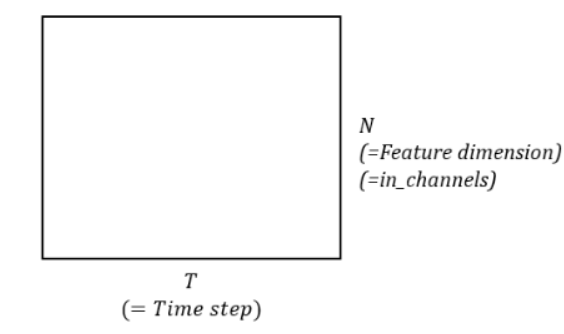

# 데이터 로더

In [22]:
EPOCHS = 50
BATCH_SIZE = 32
lr = 1e-3

In [23]:
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        
        return torch.Tensor(self.X[index]) # 테스트셋 용
    


In [24]:
train_dataset = TimeDataset(train_x, train_y)
valid_dataset = TimeDataset(valid_x, valid_y)


train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)



# 데이터 확인

In [25]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0].shape)


X_train :  torch.Size([32, 720, 11]) type: torch.FloatTensor
Y_train :  torch.Size([32, 288]) type: torch.FloatTensor
torch.Size([288])


In [26]:
#valiation set 확인
for (X_valid,Y_valid) in valid_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0].shape)

X_valid :  torch.Size([32, 720, 11]) type: torch.FloatTensor
Y_valid :  torch.Size([32, 288]) type: torch.FloatTensor
torch.Size([288])


# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [27]:
lstm = nn.LSTM(input_size=11, hidden_size=512, batch_first=True, bidirectional=False)

lstm(X_valid)[0].size()

torch.Size([32, 720, 512])

In [28]:
lstm(X_valid)[0][:,-1,:].size()

torch.Size([32, 512])

In [29]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=11, hidden_size=512, batch_first=True, bidirectional=False)
        self.classifier = nn.Sequential(
            nn.Linear(512,512),# 사이즈는 hidden size에 따라 결정.
            nn.ReLU(),
            nn.Linear(512,288), #결과 288개 예측.
            nn.ReLU(),  
        )
        
    def forward(self, x):
        hidden, _ = self.lstm(x)
        output = self.classifier(hidden[:,-1,:]) # -1은 hidden state의 마지막 time step값을 가져온 것.
        return output

In [30]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0
    train_mae_loss = 0
    for batch_idx,(X, Y) in enumerate(train_loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        optimizer.zero_grad()#데이터들 장비에 할당
        output = model(X) # model로 output을 계산
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        with torch.no_grad():
            mae = metric(output, Y)
            train_mae_loss+=mae.item()

    
    train_loss/=len(train_loader.dataset)
    train_mae_loss/=len(train_loader.dataset)
    
    return train_loss,train_mae_loss



In [31]:
#8. 학습
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    valid_mae = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for X, Y in valid_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            output = model(X) # model로 output을 계산
            
            loss = criterion(output, Y)
            valid_loss += loss.item()
            mae = metric(output, Y)
            valid_mae+=mae.item()
    valid_loss/=len(valid_loader.dataset)
    valid_mae/=len(valid_loader.dataset)
    
    return valid_loss, valid_mae


In [33]:
#학습 진행 코드


check_path = './checkpoint/checkpoint_baseline_wspd.pt'
print(check_path)
model = BaseModel().to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
metric = nn.L1Loss().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

best_valid_mae = 999999
best_valid_loss = 9999999999

for Epoch in range(1,EPOCHS+1):
    train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_mae = evaluate(model, valid_loader)
    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n".
                  format(Epoch, train_loss, train_mae, valid_loss, valid_mae))
    if best_valid_loss > valid_loss:
        print("-- SAVE Checkpoint --")
        print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_loss,valid_loss))
        torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
        best_valid_mae = valid_mae
        best_valid_loss = valid_loss
        
    
    

./checkpoint/checkpoint_baseline_wspd.pt

[EPOCH:1]	 Train Loss:0.3287	 Train MAE:0.0797  | 	Valid Loss:0.3050 	Valid MAE: 0.0768

-- SAVE Checkpoint --
Valid loss : 9999999999.0000 -> 0.3050 


[EPOCH:2]	 Train Loss:0.2893	 Train MAE:0.0747  | 	Valid Loss:0.2881 	Valid MAE: 0.0716

-- SAVE Checkpoint --
Valid loss : 0.3050 -> 0.2881 


[EPOCH:3]	 Train Loss:0.2613	 Train MAE:0.0705  | 	Valid Loss:0.2828 	Valid MAE: 0.0678

-- SAVE Checkpoint --
Valid loss : 0.2881 -> 0.2828 


[EPOCH:4]	 Train Loss:0.2387	 Train MAE:0.0669  | 	Valid Loss:0.2651 	Valid MAE: 0.0654

-- SAVE Checkpoint --
Valid loss : 0.2828 -> 0.2651 


[EPOCH:5]	 Train Loss:0.2114	 Train MAE:0.0627  | 	Valid Loss:0.2571 	Valid MAE: 0.0615

-- SAVE Checkpoint --
Valid loss : 0.2651 -> 0.2571 


[EPOCH:6]	 Train Loss:0.1883	 Train MAE:0.0587  | 	Valid Loss:0.2337 	Valid MAE: 0.0579

-- SAVE Checkpoint --
Valid loss : 0.2571 -> 0.2337 


[EPOCH:7]	 Train Loss:0.1682	 Train MAE:0.0550  | 	Valid Loss:0.2142 	Valid MAE: 0.05

# validation 확인

In [36]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.1288 / Valid MAE : 0.0321 



# train data 확인

In [138]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [139]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(156, 161)] #161,162

test_data = train_data[train_data["Day"].isin(test_data_list)]

test_data = test_data.drop(["TurbID", "Day"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [140]:
test_data.shape

(134, 720, 11)

In [141]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [142]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [143]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline_wspd.pt')
model.load_state_dict(best_checkpoint)
model.eval()

preds = predict(model, test_loader)
preds = preds.reshape(-1)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 64.08it/s]


In [144]:
preds.shape

(38592,)

In [145]:
sample_submission["Wspd"] = preds

In [146]:
sample_submission.drop(['index','Wdir','Etmp','Itmp','Ndir','Pab1','Pab2','Pab3','Prtv','Patv'],axis=1,inplace=True)

In [147]:
sample_submission.loc[sample_submission['Day']==201,'Day'] = 161

In [148]:
sample_submission.loc[sample_submission['Day']==202,'Day'] = 162

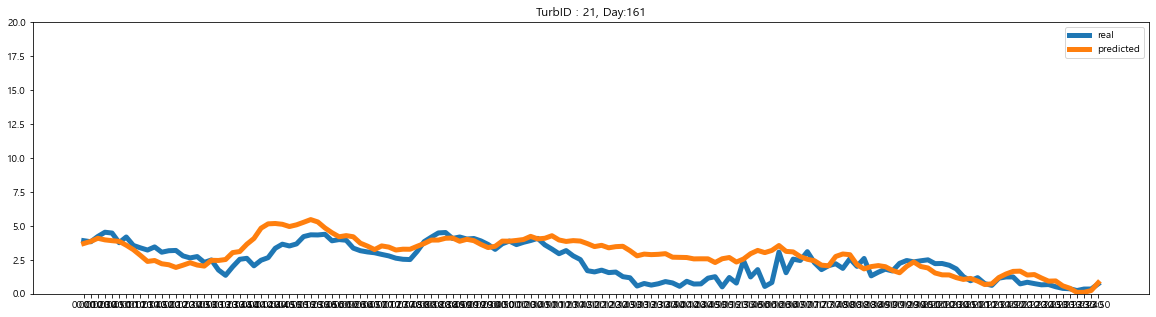

In [149]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = train_data

plt.figure(figsize=(20, 5))
j = 161 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='real')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)


plot_data = sample_submission
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='predicted')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)

plt.legend()

(0.0, 20.0)

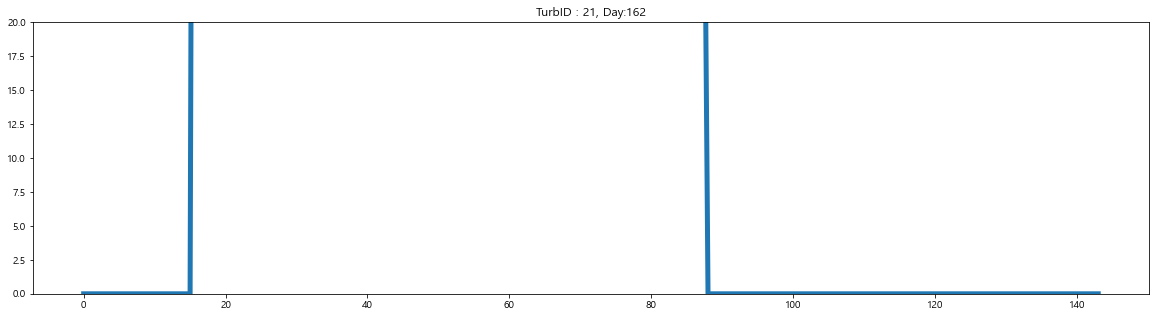

In [151]:
plot_data = train_data

plt.figure(figsize=(20, 5))
j = 162 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Patv'], linewidth=5.0,
        label='real')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)


In [ ]:
plot_data = train_data

plt.figure(figsize=(20, 5))
j = 162 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Patv'], linewidth=5.0,
        label='real')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)


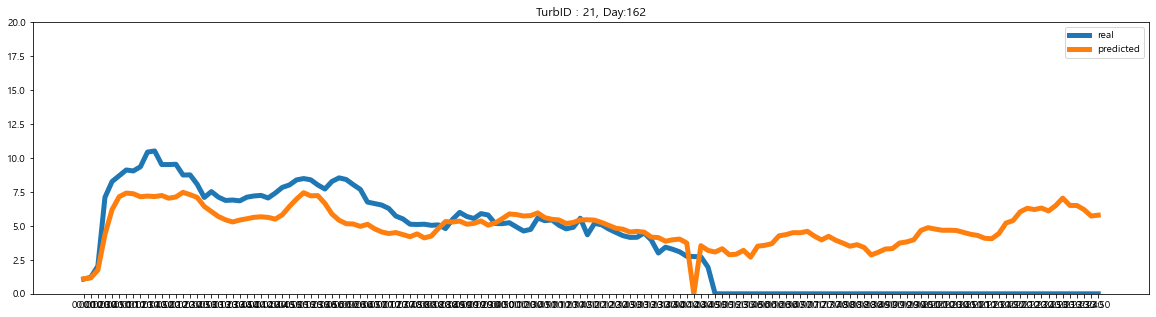

In [150]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = train_data

plt.figure(figsize=(20, 5))
j = 162 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='real')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)


plot_data = sample_submission
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='predicted')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)

plt.legend()

# 마지막 2일

In [116]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [37]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(194, 199)] #199 ,200 예측

test_data = train_data[train_data["Day"].isin(test_data_list)]

test_data = test_data.drop(["TurbID", "Day"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [38]:
test_data.shape

(134, 720, 11)

In [39]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [40]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [41]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline_wspd.pt')
model.load_state_dict(best_checkpoint)
model.eval()

preds = predict(model, test_loader)
preds = preds.reshape(-1)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 66.62it/s]


In [58]:
preds.shape

(38592,)

In [117]:
sample_submission["Wspd"] = preds

In [118]:
sample_submission.drop(['index','Wdir','Etmp','Itmp','Ndir','Pab1','Pab2','Pab3','Prtv','Patv'],axis=1,inplace=True)

In [119]:
sample_submission.loc[sample_submission['Day']==201,'Day'] = 199

In [120]:
sample_submission.loc[sample_submission['Day']==202,'Day'] = 200

In [121]:
sample_submission

,TurbID,Day,Tmstamp,Wspd
0,1,199,00:00,12.681668
1,1,199,00:10,12.644182
2,1,199,00:20,12.595867
3,1,199,00:30,12.789956
4,1,199,00:40,12.803812
...,...,...,...,...
38587,134,200,23:10,5.957911
38588,134,200,23:20,6.642547
38589,134,200,23:30,6.932070
38590,134,200,23:40,6.695208


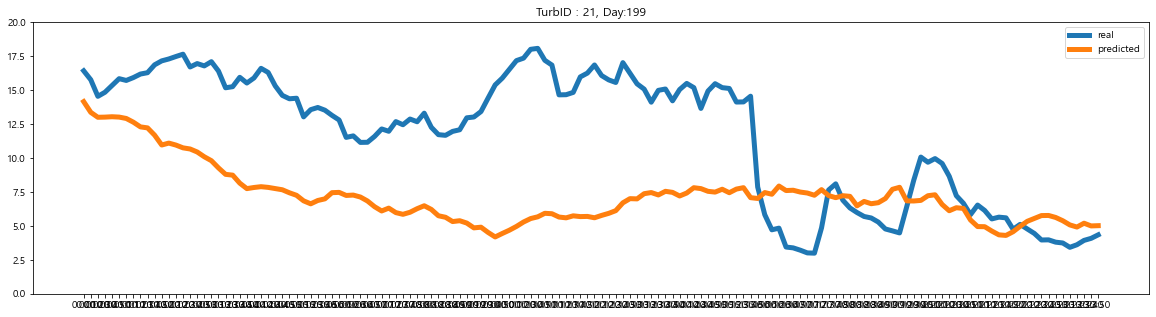

In [129]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = train_data

plt.figure(figsize=(20, 5))
j = 199 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='real')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)


plot_data = sample_submission
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='predicted')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)

plt.legend()

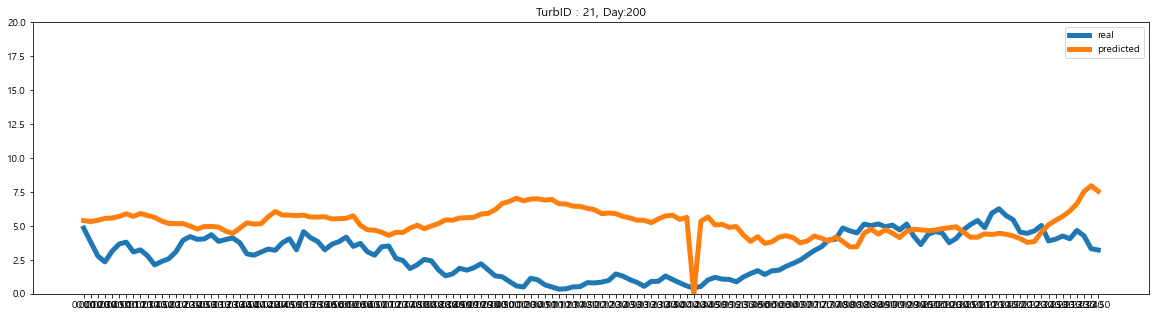

In [130]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = train_data

plt.figure(figsize=(20, 5))
j = 200 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='real')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)


plot_data = sample_submission
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0,
        label='predicted')
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)

plt.legend()

(0.0, 20.0)

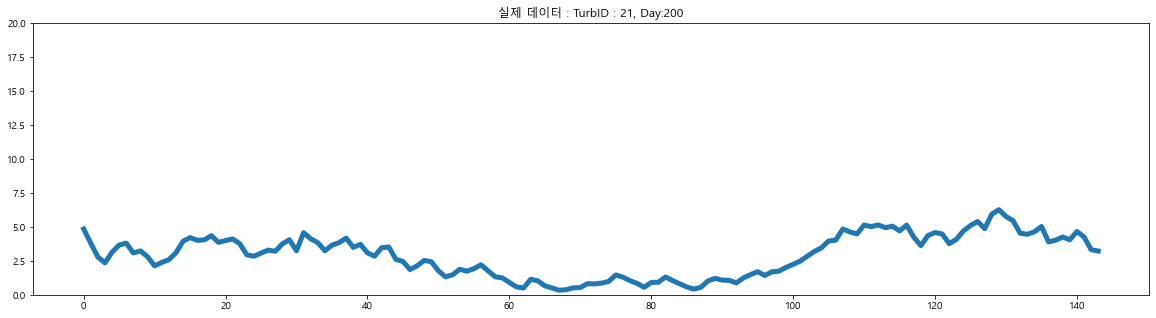

In [124]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = train_data

plt.figure(figsize=(20, 5))
j = 200 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0)
plt.title(f'실제 데이터 : TurbID : {k}, Day:{j}')
plt.ylim(0,20)

(0.0, 20.0)

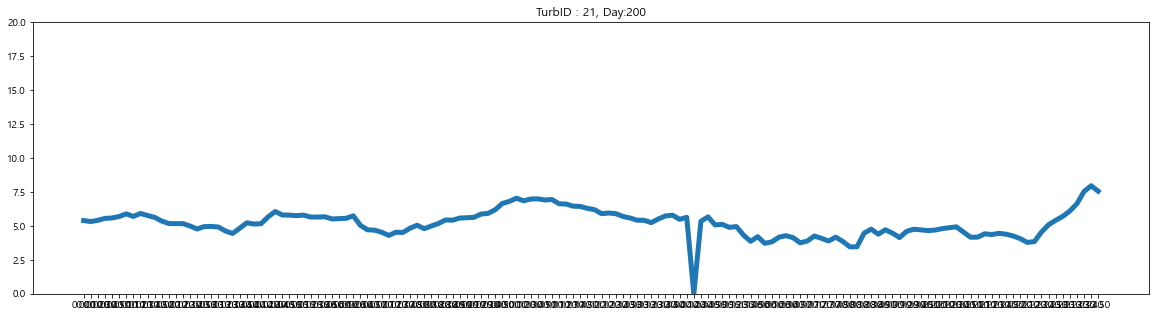

In [125]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = sample_submission

plt.figure(figsize=(20, 5))
j = 200 # Day
#for i in range(1, 135): # TurbID
#    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
k = 21 # turb id
plt.plot(plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==k) & (plot_data['Day']==j)]['Wspd'], linewidth=5.0)
plt.title(f'TurbID : {k}, Day:{j}')
plt.ylim(0,20)

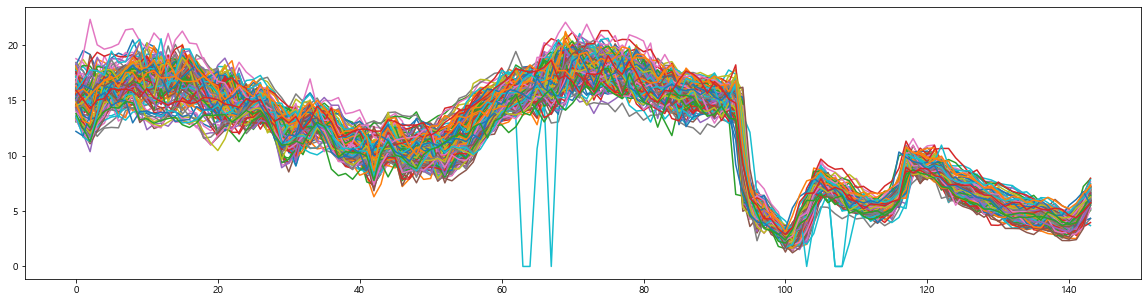

In [135]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = train_data

plt.figure(figsize=(20, 5))
j = 199 # Day
for i in range(1, 135): # TurbID
    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
#k = 21 # turb id
#plt.plot(train_data1[(train_data1['TurbID']==k) & (train_data1['Day']==j)]['Tmstamp'], train_data1[(train_data1['TurbID']==k) & (train_data1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

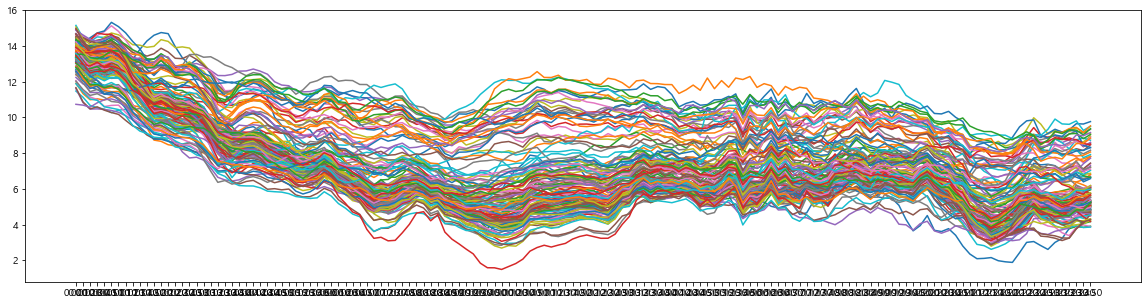

In [133]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = sample_submission

plt.figure(figsize=(20, 5))
j = 199 # Day
for i in range(1, 135): # TurbID
    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
#k = 21 # turb id
#plt.plot(train_data1[(train_data1['TurbID']==k) & (train_data1['Day']==j)]['Tmstamp'], train_data1[(train_data1['TurbID']==k) & (train_data1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

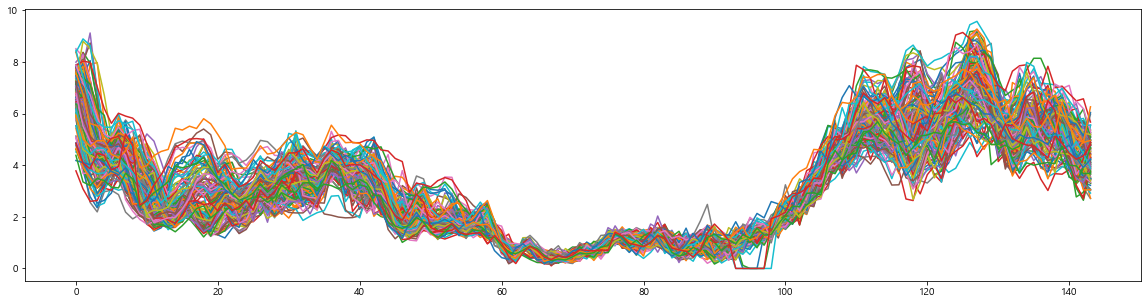

In [137]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = train_data

plt.figure(figsize=(20, 5))
j = 200 # Day
for i in range(1, 135): # TurbID
    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
#k = 21 # turb id
#plt.plot(train_data1[(train_data1['TurbID']==k) & (train_data1['Day']==j)]['Tmstamp'], train_data1[(train_data1['TurbID']==k) & (train_data1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

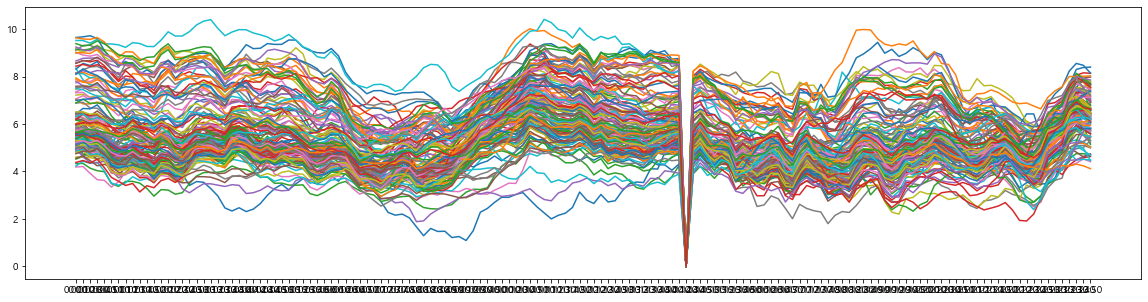

In [134]:
# Tmstamp 당 Patv 추세를 확인.
plot_data = sample_submission

plt.figure(figsize=(20, 5))
j = 200 # Day
for i in range(1, 135): # TurbID
    plt.plot(plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Tmstamp'], plot_data[(plot_data['TurbID']==i) & (plot_data['Day']==j)]['Wspd'])
    #plt.xticks([])
#k = 21 # turb id
#plt.plot(train_data1[(train_data1['TurbID']==k) & (train_data1['Day']==j)]['Tmstamp'], train_data1[(train_data1['TurbID']==k) & (train_data1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

# TEST

In [161]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [162]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(196, 201)]

test_data = train_data[train_data["Day"].isin(test_data_list)]

test_data = test_data.drop(["TurbID", "Day"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [163]:
test_data.shape

(134, 720, 11)

In [164]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [165]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [166]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline_wspd.pt')
model.load_state_dict(best_checkpoint)
model.eval()

BaseModel(
  (lstm): LSTM(11, 512, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=288, bias=True)
    (3): ReLU()
  )
)

In [167]:
preds = predict(model, test_loader)
preds = preds.reshape(-1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.29it/s]


In [168]:
sample_submission["Wspd"] = preds
sample_submission.drop(['index','Wdir','Etmp','Itmp','Ndir','Pab1','Pab2','Pab3','Prtv','Patv'],axis=1,inplace=True)

In [170]:
sample_submission

,TurbID,Day,Tmstamp,Wspd
0,1,201,00:00,4.305707
1,1,201,00:10,4.108057
2,1,201,00:20,3.685424
3,1,201,00:30,3.074389
4,1,201,00:40,2.976142
...,...,...,...,...
38587,134,202,23:10,2.220643
38588,134,202,23:20,2.064828
38589,134,202,23:30,1.566530
38590,134,202,23:40,1.315645


In [30]:
sample_submission["Patv"] = preds
sample_submission.to_csv("./submit.csv", index = False)